In [1]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer
from datasets import load_dataset
import matplotlib.pyplot as plt

# Set a seed for reproduceability
seed = 42

## Linear model: MLPs, Weight Tieing, and batch size

In this notebook, we explore what happens if we turn the final lm_head output layer into a couple of MLP layers, keeping the parameter count around 50M. We also add some complexity to the training loop such as batch size and warmup steps.  



In [2]:
# Set Tokenizer

# 512 is a good minimal context length in principle large enough to understand paragraphs
context_length = 512

# The original Llama 2 tokenizer is available from Huggingface, but we will use the more
# up-to-date Cosmo2 toenizer provided by Huggingface for the Llama-like SmolLM models
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/cosmo2-tokenizer")
tokenizer.model_max_length = context_length
# There are times we need to pad.  We will make the padding token the same one that 
# signals end of sentance.
tokenizer.pad_token = tokenizer.eos_token

In [3]:
# Set dataset

# Set batch size
batch_size = 8

# Load dataset from hugging face in streaming mode.
dataset = load_dataset("HuggingFaceTB/smollm-corpus", "cosmopedia-v2", split="train", streaming=True)

# Create a tokenize fundtion.
def tokenize(item):
    x = tokenizer(
        item['text'],
        truncation=True,
        padding=True,
        max_length=context_length,
        return_tensors="pt",
    )

    return x


tokenized_dataset = dataset.map(
    tokenize, batched=True, remove_columns=dataset.column_names
)
train_dl = DataLoader(dataset=tokenized_dataset, batch_size=batch_size)

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/104 [00:00<?, ?it/s]

### Building linear model

Now let's make a linear model using a couple of back to back MLPs with Relu activation functions to explore if this is superior to just the embedding layer with linear output, assuming parameters are fixed to roughly 50M parameters.  

In [4]:
# We will inherit from Pytorch's Module class
class LinearModel(nn.Module):
    def __init__(self, vocab_size: int, n_embed: int):
        super().__init__()

        # Map tokens to embedding space with dimension n_embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim=n_embed)

        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

        self.fft1 = nn.Sequential(nn.Linear(n_embed, 4*n_embed),
                                 nn.ReLU(),
                                 nn.Linear(4*n_embed, n_embed))
        
        self.fft2 = nn.Sequential(nn.Linear(n_embed, 4*n_embed),
                                 nn.ReLU(),
                                nn.Linear(4*n_embed, n_embed))
                               

        # Now map back to make prediction for next tokens, called logits.  The layer that
        # does this is traditionally a linear layer called the lannguage model head.
        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.embedding.weight = self.lm_head.weight
        

    # Pytorch Modules have a forward method that is what is executed when the model is called
    # The input is the (batch, tokens) tensor and a (batch, logits) tensor is returned
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = x + self.fft1(self.ln1(x))
        x = x + self.fft2(self.ln2(x))
        logits = self.lm_head(x)
        return logits

In [5]:
# Let's create the model
model = LinearModel(vocab_size = tokenizer.vocab_size, n_embed=832)

# Let's see how many parameters we have
print (sum([p.numel() for p in model.parameters()])/1.0e6)


51.981696


### The Training Loop

Let's add the batch size to be 250k tokens.  Like Smallest Llama models. 

In [6]:
device = "mps"
model = model.to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
accum_iter = 128 // batch_size

num_params = sum([p.numel() for p in model.parameters()]) / 1.0e6
print(f"This model has {num_params:.2f}M  params")
print(
    f"The vocab size is {tokenizer.vocab_size}, meaning the initial loss should be ~{math.log(tokenizer.vocab_size):.3f}"
)
model.train()
step_losses = []
losses = []
for step, batch in enumerate(train_dl):

    # Get data
    x = batch["input_ids"].to(device)
    att_mask = batch["attention_mask"].to(device)

    # Compute prediction error
    logits = model(x)

    # Shift to compare loss correctly
    shifted_logits = logits[:, :-1].contiguous()
    labels = x[:, 1:].contiguous()
    loss = loss_fn(shifted_logits.view(-1, shifted_logits.size(-1)), labels.view(-1))
    loss = loss / accum_iter

    # Backpropagation
    loss.backward()
    step_losses.append(loss.item())

    if (step + 1) % accum_iter == 0:
        optimizer.step()
        optimizer.zero_grad()
        losses.append(sum(step_losses[-accum_iter:]))

        acc_step = (step + 1) // accum_iter
        if (acc_step - 1) % 100 == 0:
            print(
                #f"Step: {acc_step:>5d},  Tokens:{batch_size*context_length*accum_iter*acc_step/1.0e6:>7.3f}M,  Loss: {losses[-1]:>7.3f}, Perplexity:  {math.exp(losses[-1]):>7.1f}"
                f"Step: {acc_step:>5d},  Tokens:{batch_size*context_length*accum_iter*acc_step/1.0e6:>7.3f}M, Loss: {losses[-1]:>7.3f}, Loss_ave: {sum(losses[-100:])/len(losses[-100:]):>7.3f}, Perplexity:  {math.exp(losses[-1]):>7.1f}"
            )
    if (step + 1) % 25000 == 0:
        break
    # Step:   501,  Tokens: 32.834M,  Loss:   6.160, Perplexity:    473.4
    # Step:  1001,  Tokens: 65.602M,  Loss:   5.130, Perplexity:    169.0

This model has 51.98M  params
The vocab size is 49152, meaning the initial loss should be ~10.803


TypeError: object of type 'float' has no len()

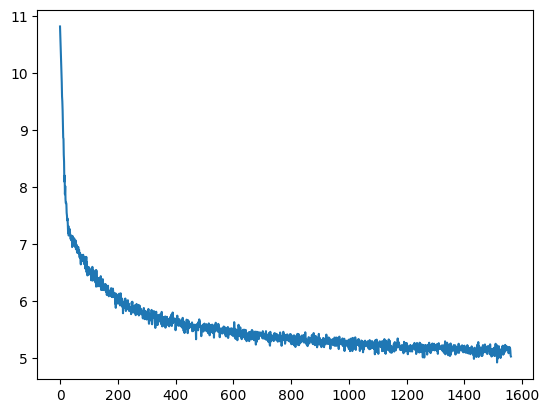

In [ ]:
plt.plot(losses)

In [ ]:
# Assuming the embedding layer is already trained
layer = model.embedding.to('cpu')

# Get the embedding for 'king' (e.g., assuming 'king' corresponds to token index 0)
k = 200
word = 'king'

print (f"Input ids for {word} is {tokenizer(word)['input_ids']}")

word_index = tokenizer(word)['input_ids'][0]
word_embedding = layer(torch.tensor(word_index)).detach()  # Get the embedding for 'king'

# Get all embeddings
all_embeddings = layer.weight.detach()  # Extract all embeddings


# Compute cosine similarity between 'king' and all other tokens
cosine_similarities = F.cosine_similarity(word_embedding.unsqueeze(0), all_embeddings, dim=1)

# Get the indices of the 10 most similar tokens (excluding 'king' itself)
top_k = torch.topk(cosine_similarities, k=k+1)  # Top 11 because 'king' will be in the list
top_k_indices = top_k.indices[top_k.indices != word_index][:k]  # Exclude 'king'


# Print the 10 closest tokens and their similarities
print(f"Top 25 closest tokens to {word} by cosine similarity: ")
ii = 0
for idx in top_k_indices:
    #print(idx.item())
    idx_word = tokenizer.decode(idx.item()).replace('\n','')
    if len(idx_word) > 4:
        print(f"Token: {idx.item():5d}, {idx_word:>14s},   Similarity: {cosine_similarities[idx].item():.4f}")
        ii += 1
        if ii > 24:
            break





Input ids for king is [644]
Top 25 closest tokens to king by cosine similarity: 
Token: 44520,      approving,   Similarity: 0.1746
Token: 16593,        reading,   Similarity: 0.1673
Token:  2934,        inating,   Similarity: 0.1492
Token: 21046,        tically,   Similarity: 0.1471
Token:  2442,          erous,   Similarity: 0.1443
Token:  1883,          aging,   Similarity: 0.1431
Token:  6605,          dered,   Similarity: 0.1398
Token:  8069,          orate,   Similarity: 0.1393
Token: 14642,          mount,   Similarity: 0.1356
Token: 43601,         rasing,   Similarity: 0.1343
Token: 41592,          fight,   Similarity: 0.1343
Token: 26649,         pering,   Similarity: 0.1329
Token:  9646,         usalem,   Similarity: 0.1323
Token: 38491,        fecture,   Similarity: 0.1313
Token:   309,          ation,   Similarity: 0.1305
Token:   674,          ating,   Similarity: 0.1300
Token: 29899,       revolves,   Similarity: 0.1294
Token: 32105,      swallowed,   Similarity: 0.1284
T

In [9]:
distances = torch.norm(all_embeddings - word_embedding, dim=1)  # Compute L2 norm (Euclidean distance)

# Get the indices of the 10 closest tokens (excluding 'king' itself)
top_k = torch.topk(-distances, k=k+1)  # Use negative distances to mimic \"closest\"
top_k_indices = top_k.indices[top_k.indices != word_index][:k]  # Exclude 'king'

# Print the 10 closest tokens and their distances
print(f"\nTop 25 closest tokens to {word} by distance: ")
ii = 0
for idx in top_k_indices:
    #print(idx.item())
    idx_word = tokenizer.decode(idx.item()).replace('\n','')
    if len(idx_word) > 4:    
        print(f"Token: {idx.item():5d}, {tokenizer.decode(idx.item()).replace('\n',''):>14s},   Distance: {distances[idx].item():.2f}")
        ii += 1
        if ii > 24:
            break



Top 25 closest tokens to king by distance: 
Token: 32105,      swallowed,   Distance: 0.85
Token: 39225,          hurst,   Distance: 0.86
Token: 24948,         Studio,   Distance: 0.86
Token: 26027,           Joan,   Distance: 0.86
Token: 28938,         Esther,   Distance: 0.86
Token: 14004,        melting,   Distance: 0.86
Token:  7611,       bringing,   Distance: 0.86
Token: 16593,        reading,   Distance: 0.86
Token: 48489,      detainees,   Distance: 0.86
Token: 45184,       snapping,   Distance: 0.86
Token: 32808,        soaking,   Distance: 0.87
Token: 43555,          deton,   Distance: 0.87
Token: 32415,         watery,   Distance: 0.87
Token: 22630,          Cloud,   Distance: 0.87
Token: 40984,        walking,   Distance: 0.87
Token: 45614,          Britt,   Distance: 0.87
Token: 22063,       thirteen,   Distance: 0.87
Token: 43429,        perched,   Distance: 0.87
Token: 41592,          fight,   Distance: 0.87
Token: 46961,         chakra,   Distance: 0.87
Token: 15656,  

In [ ]:
class MultiHeadedSelfAttention(nn.Module):
    def __init__(self, n_heads: int, n_embed: int):
        super().__init__()

        assert n_embed % n_heads == 0, "Number of heads muct divide embedding dimension"
        self.n_heads = n_heads
        self.h_dim = n_embed // n_heads

        self.k = nn.Linear(n_embed, n_embed)
        self.q = nn.Linear(n_embed, n_embed)
        self.v= nn.Linear(n_embed, n_embed)

        self.proj_out= nn.Linear(n_embed, n_embed)

    def forward (self, x: torch.Tensor) -> torch.Tensor:
        B, T, C = x.shape

        # (B, T, C) -> (B, T, n_heads, h_dim) -> (B, n_heads, T, h_dim)
        q = self.q(x).view(B, T, self.n_heads, self.h_dim).transpose(1,2)
        k = self.k(x).view(B, T, self.n_heads, self.h_dim).transpose(1,2)
        v = self.v(x).view(B, T, self.n_heads, self.h_dim).transpose(1,2)

        x = F.scaled_dot_product_attention(q, k, v, is_causal=True)

        # (B, n_heads, T, h_dim) -> (B, T, n_heads, h_dim) -> (B, T, C)
        x.transpose(1, 2).contiguous().view(B, T, C)

        return self.proj_out(x)


# We will inherit from Pytorch's Module class
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size: int, n_embed: int, n_heads: int):
        super().__init__()

        # Map tokens to embedding space with dimension n_embed
        self.embedding = nn.Embedding(vocab_size, embedding_dim=n_embed)

        self.attn = MultiHeadedSelfAttention(n_heads, n_embed)
        
        self.fft = nn.Sequential(nn.Linear(n_embed, 4*n_embed),
                                 nn.ReLU(),
                                 nn.Linear(n_embed, 4*n_embed))
                               

        # Now map back to make prediction for next tokens, called logits.  The layer that
        # does this is traditionally a linear layer called the lannguage model head.
        self.lm_head = nn.Linear(n_embed, vocab_size, bias=False)
        self.embedding.weight = self.lm_head.weight
        

    # Pytorch Modules have a forward method that is what is executed when the model is called
    # The input is the (batch, tokens) tensor and a (batch, logits) tensor is returned
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.embedding(x)
        x = self.attn(x)
        x = self.fft(x)
        logits = self.lm_head(x)
        return logits
    
# Let's create the model
model = EmbeddingModel(vocab_size = tokenizer.vocab_size, n_embed=832, n_heads=13)

# Let's see how many parameters we have
print (sum([p.numel() for p in model.parameters()])/1.0e6)


49.211136
